<a href="https://colab.research.google.com/github/Shivp55/DAML/blob/main/DAML2_OBJ_DET_CLASSFTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision import transforms
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the path to save the combined folder in Google Drive
google_drive_path = '/content/drive/MyDrive/combined_dataset'

# Create the directory if it doesn't exist
if not os.path.exists(google_drive_path):
    os.makedirs(google_drive_path)


In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download("karthika95/pedestrian-detection")
print("Path to dataset files:", dataset_path)


100%|██████████| 187M/187M [00:01<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karthika95/pedestrian-detection/versions/1


In [5]:
# Define paths
train_img_dir = Path(dataset_path) / "Train/Train/JPEGImages"
train_annot_dir = Path(dataset_path) / "Train/Train/Annotations"

val_img_dir = Path(dataset_path) / "Val/Val/JPEGImages"
val_annot_dir = Path(dataset_path) / "Val/Val/Annotations"


In [ ]:
# Define the directories
combined_img_dir = Path(google_drive_path) / "images"
combined_annot_dir = Path(google_drive_path) / "annotations"

# Create directories for training and validation sets
train_img_dir = Path(google_drive_path) / "train_images"
train_annot_dir = Path(google_drive_path) / "train_annotations"
val_img_dir = Path(google_drive_path) / "val_images"
val_annot_dir = Path(google_drive_path) / "val_annotations"

# Create the directories if they don't exist
train_img_dir.mkdir(parents=True, exist_ok=True)
train_annot_dir.mkdir(parents=True, exist_ok=True)
val_img_dir.mkdir(parents=True, exist_ok=True)
val_annot_dir.mkdir(parents=True, exist_ok=True)

# List all image files in the combined image directory
image_files = list(combined_img_dir.glob("*.[jp][pn]g"))  # Find jpg, jpeg, and png images

# Ensure random shuffling for a random split
random.shuffle(image_files)

# Split the data (at least 1000 for training, rest for validation)
train_images = image_files[:1024]
val_images = image_files[1024:]

# Copy the images and their corresponding annotations to the new directories
def copy_images_and_annotations(image_files, src_img_dir, src_annot_dir, dest_img_dir, dest_annot_dir):
    for img_file in image_files:
        # Find the corresponding annotation file
        annot_file = img_file.stem + ".xml"
        src_annot_path = src_annot_dir / annot_file

        if src_annot_path.exists():
            # Copy image and annotation to respective directories
            shutil.copy(img_file, dest_img_dir / img_file.name)
            shutil.copy(src_annot_path, dest_annot_dir / annot_file)

# Copy the training set images
copy_images_and_annotations(train_images, combined_img_dir, combined_annot_dir, train_img_dir, train_annot_dir)

# Copy the validation set images
copy_images_and_annotations(val_images, combined_img_dir, combined_annot_dir, val_img_dir, val_annot_dir)

# Verify the number of images in the training and validation directories
train_images_count = len(list(train_img_dir.glob("*.[jp][pn]g")))
val_images_count = len(list(val_img_dir.glob("*.[jp][pn]g")))

print(f"Total training images: {train_images_count}")
print(f"Total validation images: {val_images_count}")


Total training images: 1099
Total validation images: 155


In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [7]:
# ==================== Data Preparation ====================

class PedestrianDetectionDataset(Dataset):
    def __init__(self, img_dir, annot_dir, transform=None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        annot_path = os.path.join(self.annot_dir, img_filename.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml'))

        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        # Parse XML annotation
        tree = ET.parse(annot_path)
        root = tree.getroot()

        # Initialize variables
        label = 0  # Default to background
        bbox = [0, 0, 0, 0]  # Default bbox

        # Find first object (assuming at least one exists)
        obj = root.find("object")
        if obj is not None:
            # Get label
            name = obj.find("name")
            if name is not None:
                label = 0 if name.text.lower() == "person" else 1

            # Get bbox
            bndbox = obj.find("bndbox")
            if bndbox is not None:
                xmin = max(0, int(float(bndbox.find("xmin").text)))
                ymin = max(0, int(float(bndbox.find("ymin").text)))
                xmax = min(width, int(float(bndbox.find("xmax").text)))
                ymax = min(height, int(float(bndbox.find("ymax").text)))
                bbox = [xmin/width, ymin/height, xmax/width, ymax/height]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label] + bbox, dtype=torch.float32)


In [8]:
# Enhanced transformations with proper normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for more detail
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Slight rotation and translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # ImageNet stats

# For validation/test - no augmentation
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
# ==================== Main Execution ====================

# Assuming you've set up your dataset paths correctly
# Create directories for training and validation sets
train_img_dir = Path(google_drive_path) / "train_images"
train_annot_dir = Path(google_drive_path) / "train_annotations"
val_img_dir = Path(google_drive_path) / "val_images"
val_annot_dir = Path(google_drive_path) / "val_annotations"
test_img_dir = Path(dataset_path) / "Test/Test/JPEGImages"
test_annot_dir = Path(dataset_path) / "Test/Test/Annotations"
# Create datasets
train_dataset = PedestrianDetectionDataset(train_img_dir, train_annot_dir, transform=transform)
val_dataset = PedestrianDetectionDataset(val_img_dir, val_annot_dir, transform=val_transform)
test_dataset = PedestrianDetectionDataset(test_img_dir, test_annot_dir, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [100]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Adjust input size based on image dimensions
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 1)  # Output for classification
        self.bbox_head = nn.Linear(128, 4)  # Output for bounding box regression

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        class_out = torch.sigmoid(self.fc2(x))
        bbox_out = self.bbox_head(x)
        return class_out, bbox_out

# Initialize the basic model
model = BasicModel().to(device)

# Define optimizer (example: Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# ==================== Training Setup ====================

def calculate_iou(pred_boxes, true_boxes):
    """
    Calculate Intersection over Union (IoU) between predicted and true bounding boxes
    """
    # Convert from center-width to coordinates
    pred_boxes = pred_boxes.clone().detach()
    true_boxes = true_boxes.clone().detach()

    # Calculate intersection coordinates
    x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])

    # Calculate intersection area
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Calculate union area
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
    union = pred_area + true_area - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-6)

    return iou.mean().item()

In [11]:
def train_model(model, train_loader, val_loader, optimizer, device, epochs=25):
    # Loss functions
    cls_criterion = nn.BCELoss()
    bbox_criterion = nn.SmoothL1Loss()

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_iou': [], 'val_iou': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        running_iou = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            # Separate classification and regression targets
            cls_targets = targets[:, 0].unsqueeze(1)
            bbox_targets = targets[:, 1:]

            # Forward pass
            optimizer.zero_grad()
            cls_out, bbox_out = model(images)

            # Calculate losses
            cls_loss = cls_criterion(cls_out, cls_targets)
            bbox_loss = bbox_criterion(bbox_out, bbox_targets)

            # Combined loss (with different weights)
            loss = cls_loss + 5 * bbox_loss  # Adjusted weight for bbox

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            preds = (cls_out > 0.5).float()
            correct += (preds == cls_targets).sum().item()
            total += cls_targets.size(0)

            # Calculate IoU
            iou = calculate_iou(bbox_out, bbox_targets)
            running_iou += iou * images.size(0)

        # Calculate epoch metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_iou = running_iou / len(train_loader.dataset)

        # Validation phase
        val_loss, val_acc, val_iou = evaluate_model(model, val_loader, cls_criterion, bbox_criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | '
              f'Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}')

    # Plot training history
    plt.figure(figsize=(18, 6))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU plot
    plt.subplot(1, 3, 3)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('BBox IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

Epoch 1/25: Train Loss: 4.0127 | Val Loss: 0.8493 | Train Acc: 0.5378 | Val Acc: 0.5613 | Train IoU: 0.1276 | Val IoU: 0.2108
Epoch 2/25: Train Loss: 0.7906 | Val Loss: 0.8335 | Train Acc: 0.5814 | Val Acc: 0.6129 | Train IoU: 0.2759 | Val IoU: 0.2101
Epoch 3/25: Train Loss: 0.7702 | Val Loss: 0.7923 | Train Acc: 0.6215 | Val Acc: 0.6065 | Train IoU: 0.2825 | Val IoU: 0.2360
Epoch 4/25: Train Loss: 0.7463 | Val Loss: 0.7567 | Train Acc: 0.6369 | Val Acc: 0.6129 | Train IoU: 0.2973 | Val IoU: 0.2437
Epoch 5/25: Train Loss: 0.7280 | Val Loss: 0.7414 | Train Acc: 0.6661 | Val Acc: 0.7226 | Train IoU: 0.2951 | Val IoU: 0.2437
Epoch 6/25: Train Loss: 0.7212 | Val Loss: 0.7262 | Train Acc: 0.6697 | Val Acc: 0.6968 | Train IoU: 0.2970 | Val IoU: 0.2451
Epoch 7/25: Train Loss: 0.7044 | Val Loss: 0.7112 | Train Acc: 0.6888 | Val Acc: 0.7161 | Train IoU: 0.2970 | Val IoU: 0.2493
Epoch 8/25: Train Loss: 0.7036 | Val Loss: 0.7025 | Train Acc: 0.6788 | Val Acc: 0.7484 | Train IoU: 0.2992 | Val IoU:

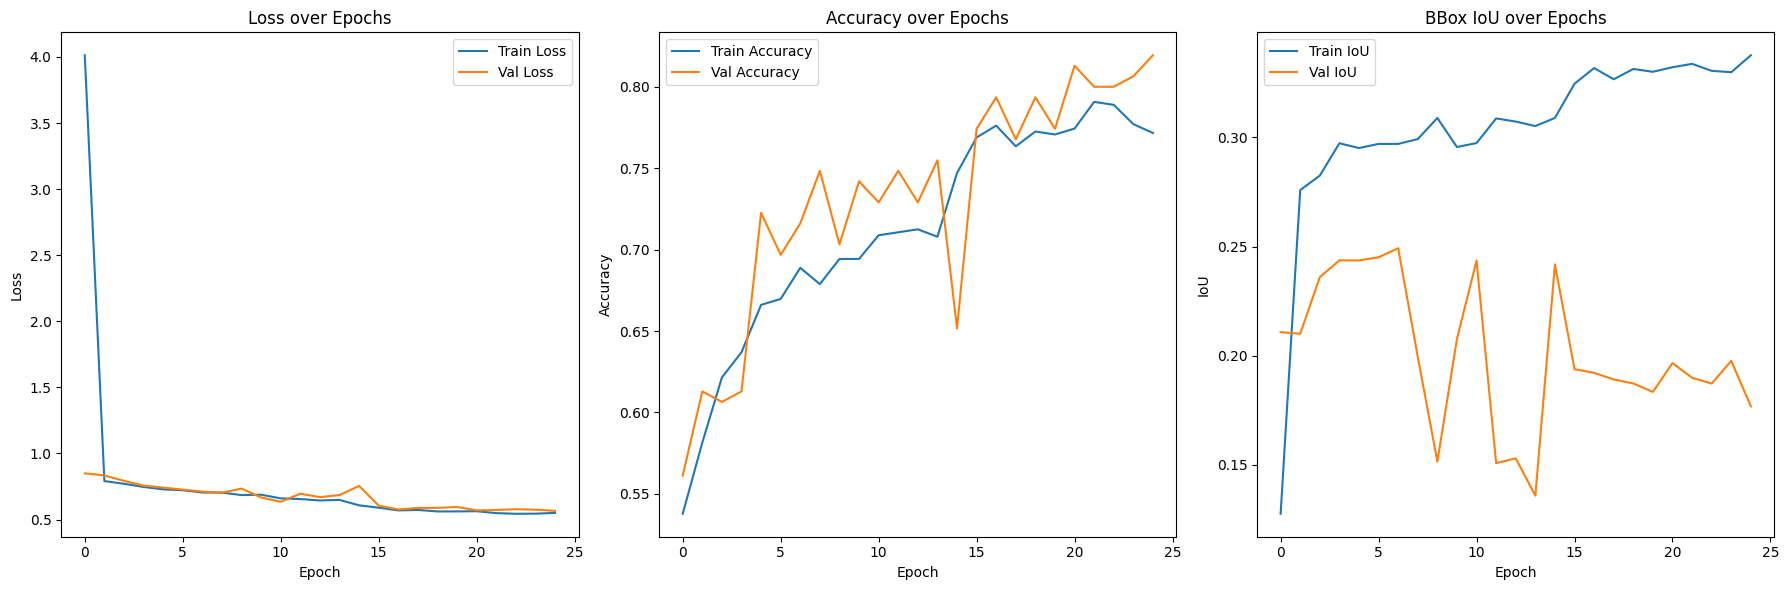

In [93]:
# Train the model (using the existing train_model function)
history = train_model(model, train_loader, val_loader, optimizer, device, epochs=25)


In [12]:
def evaluate_model(model, dataloader, cls_criterion, bbox_criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    running_iou = 0.0

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            cls_targets = targets[:, 0].unsqueeze(1)
            bbox_targets = targets[:, 1:]

            cls_out, bbox_out = model(images)

            # Calculate losses
            cls_loss = cls_criterion(cls_out, cls_targets)
            bbox_loss = bbox_criterion(bbox_out, bbox_targets)
            loss = cls_loss + 5 * bbox_loss

            # Statistics
            running_loss += loss.item() * images.size(0)
            preds = (cls_out > 0.5).float()
            correct += (preds == cls_targets).sum().item()
            total += cls_targets.size(0)

            # Calculate IoU
            iou = calculate_iou(bbox_out, bbox_targets)
            running_iou += iou * images.size(0)

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    avg_iou = running_iou / len(dataloader.dataset)

    return avg_loss, accuracy, avg_iou

In [94]:
# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_iou = evaluate_model(
    model, test_loader,
    nn.BCELoss(), nn.SmoothL1Loss(), device
)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test BBox IoU: {test_iou:.4f}")


Final Test Results:
Test Loss: 0.7888
Test Accuracy: 0.6426
Test BBox IoU: 0.1492


In [95]:
# prompt: rename model to baseline model and save to drvie

# Save the baseline model to Google Drive
model_save_path = "/content/drive/MyDrive/combined_dataset/baseline_model.pth"
torch.save(model.state_dict(), model_save_path)


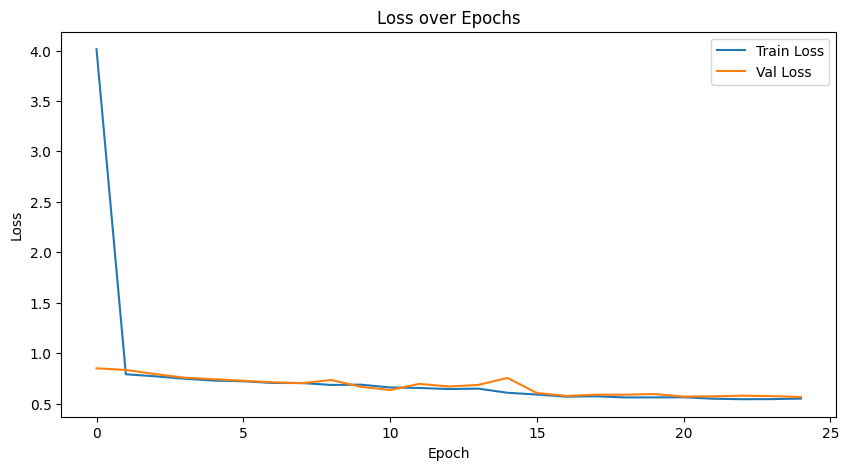

In [96]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

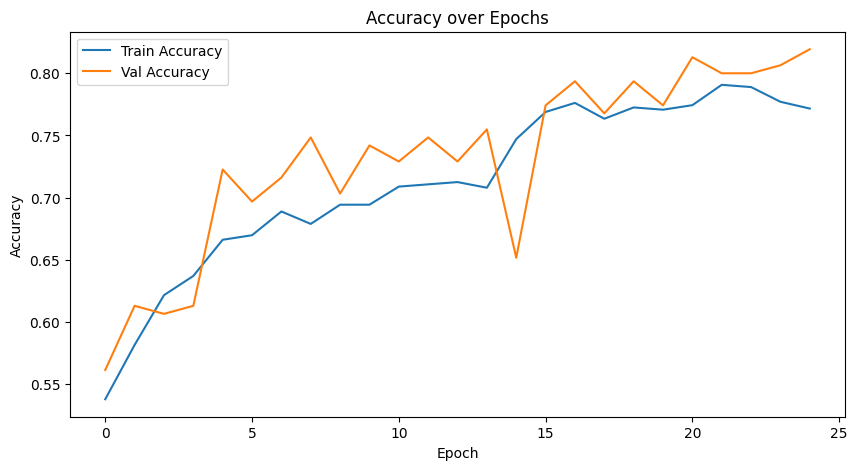

In [97]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
def predict_and_visualize(model, image_path, device, val_transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = val_transform(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        cls_out, bbox_out = model(image_tensor)

    # Process the prediction
    predicted_class = (cls_out > 0.5).float().item()
    bbox = bbox_out.squeeze().cpu().numpy()

    # Display the image and bounding box
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    if predicted_class == 1:  # If a person is detected
      width, height = image.size
      xmin = int(bbox[0] * width)
      ymin = int(bbox[1] * height)
      xmax = int(bbox[2] * width)
      ymax = int(bbox[3] * height)

      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.set_title("Person Detected")
    else:
      ax.set_title("No Person Detected")
    plt.show()

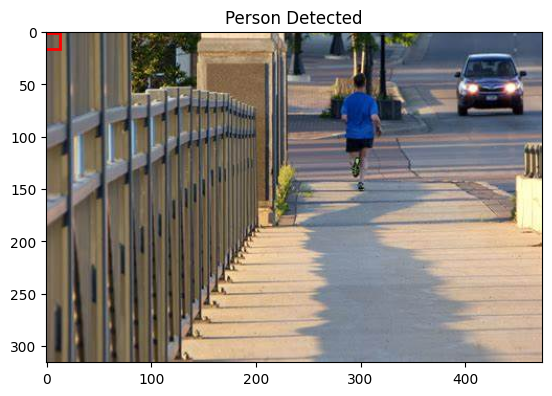

In [101]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped1.jpg', device, val_transform)


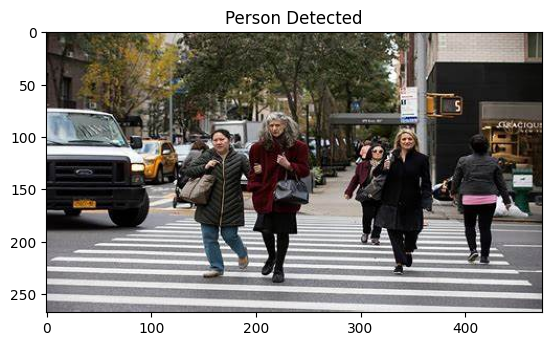

In [102]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped.jpg', device, val_transform)


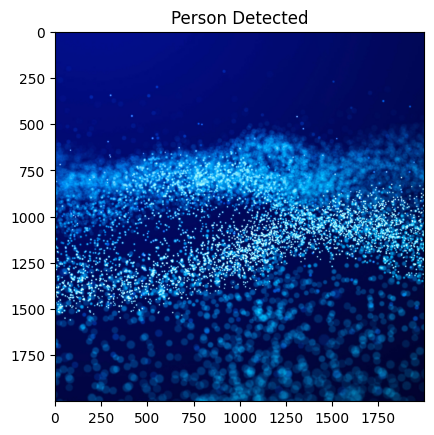

In [103]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg.jpg', device, val_transform)


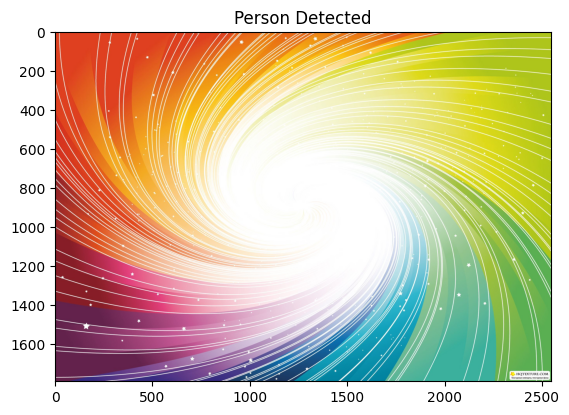

In [104]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg2.jpg', device, val_transform)


In [14]:
# prompt: improve the baseline model by adding a few drouptout and more layers and features to improve detection

import torch.nn as nn

class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 1) # Output for classification
        self.bbox_head = nn.Linear(256, 4)  # Output for bounding box regression

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.conv1(x))))
        x = self.pool2(self.dropout2(self.relu2(self.conv2(x))))
        x = self.pool3(self.dropout3(self.relu3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout4(self.relu4(self.fc1(x)))
        x = self.dropout5(self.relu5(self.fc2(x)))
        class_out = torch.sigmoid(self.fc3(x))
        bbox_out = self.bbox_head(x)
        return class_out, bbox_out

# Initialize the improved model
model = ImprovedModel().to(device)

# Define optimizer (example: Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25: Train Loss: 2.2127 | Val Loss: 1.1948 | Train Acc: 0.5823 | Val Acc: 0.5355 | Train IoU: 0.1199 | Val IoU: 0.0124
Epoch 2/25: Train Loss: 0.8223 | Val Loss: 1.1075 | Train Acc: 0.6115 | Val Acc: 0.6581 | Train IoU: 0.2225 | Val IoU: 0.0268
Epoch 3/25: Train Loss: 0.8027 | Val Loss: 1.0357 | Train Acc: 0.6297 | Val Acc: 0.7032 | Train IoU: 0.2295 | Val IoU: 0.0384
Epoch 4/25: Train Loss: 0.7795 | Val Loss: 0.9703 | Train Acc: 0.6506 | Val Acc: 0.6645 | Train IoU: 0.2397 | Val IoU: 0.0588
Epoch 5/25: Train Loss: 0.7681 | Val Loss: 0.9202 | Train Acc: 0.6497 | Val Acc: 0.6903 | Train IoU: 0.2525 | Val IoU: 0.0767
Epoch 6/25: Train Loss: 0.7601 | Val Loss: 0.8496 | Train Acc: 0.6524 | Val Acc: 0.6645 | Train IoU: 0.2537 | Val IoU: 0.1257
Epoch 7/25: Train Loss: 0.7311 | Val Loss: 0.7736 | Train Acc: 0.6879 | Val Acc: 0.6903 | Train IoU: 0.2556 | Val IoU: 0.1678
Epoch 8/25: Train Loss: 0.7334 | Val Loss: 0.7083 | Train Acc: 0.6706 | Val Acc: 0.7806 | Train IoU: 0.2502 | Val IoU:

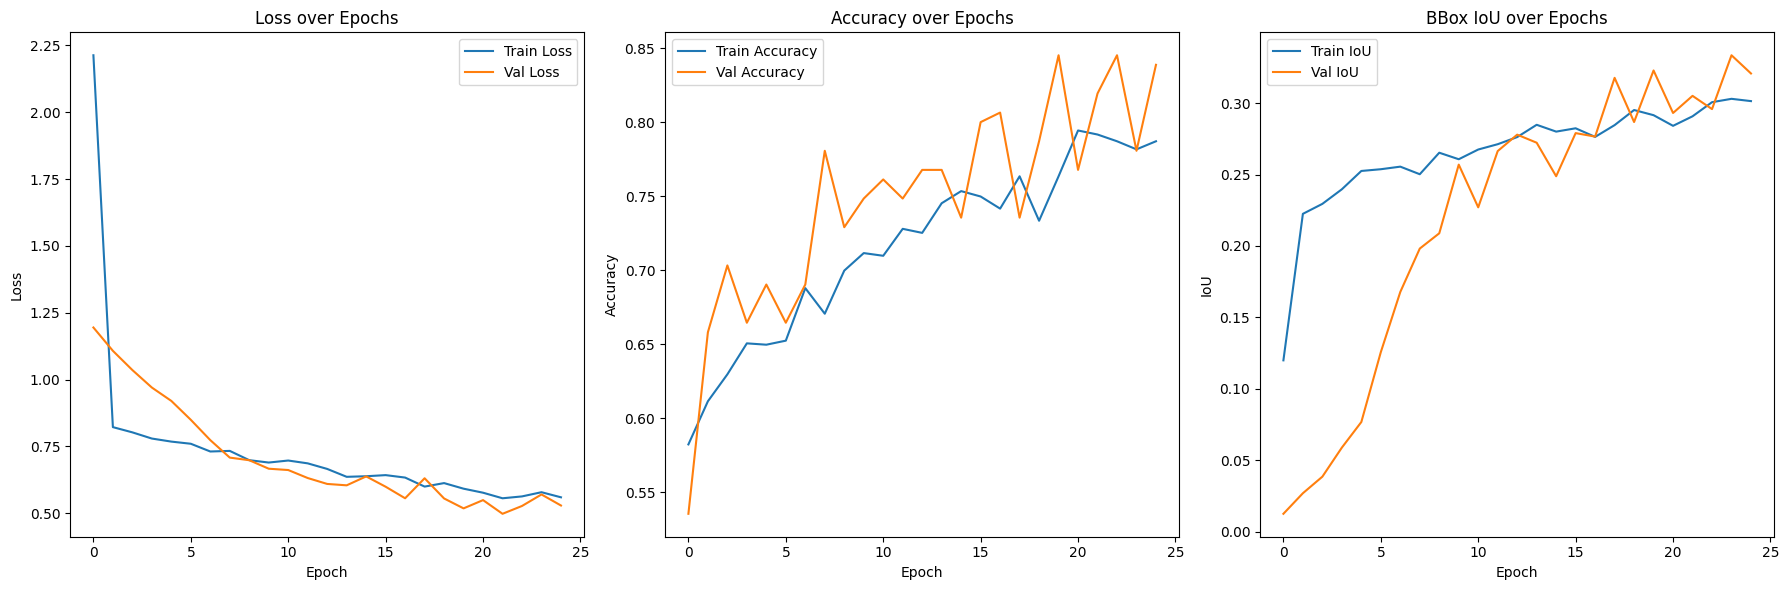

In [15]:
# Train the model (using the existing train_model function)
history = train_model(model, train_loader, val_loader, optimizer, device, epochs=25)


In [16]:
# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_iou = evaluate_model(
    model, test_loader,
    nn.BCELoss(), nn.SmoothL1Loss(), device
)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test BBox IoU: {test_iou:.4f}")


Final Test Results:
Test Loss: 0.6243
Test Accuracy: 0.7106
Test BBox IoU: 0.2857


In [17]:
# prompt: rename model to baseline model and save to drvie

# Save the baseline model to Google Drive
model_save_path = "/content/drive/MyDrive/combined_dataset/baseline_model_improved.pth"
torch.save(model.state_dict(), model_save_path)


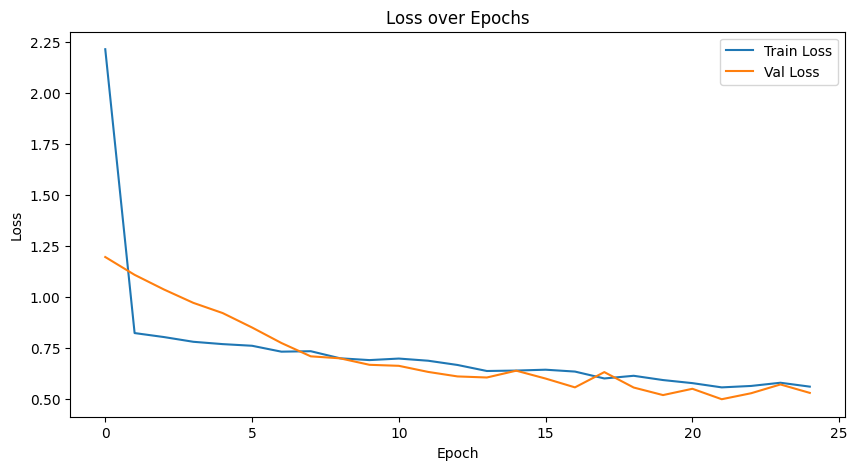

In [18]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

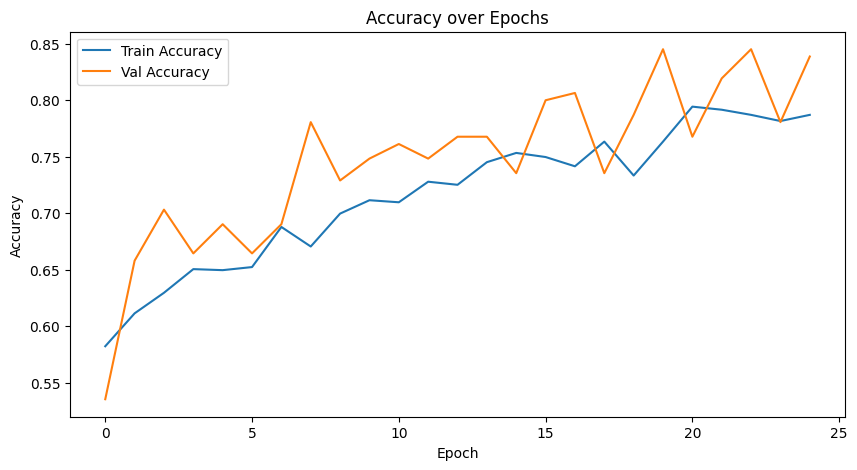

In [19]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

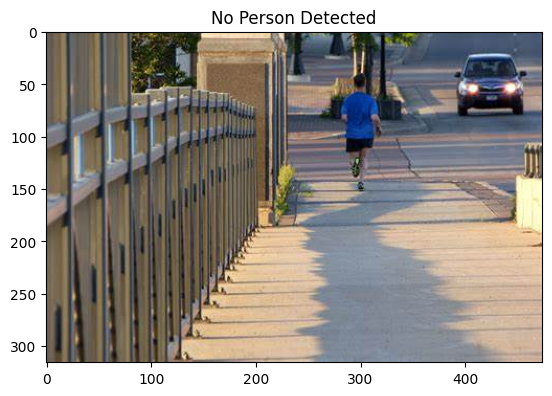

In [25]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped1.jpg', device, val_transform)


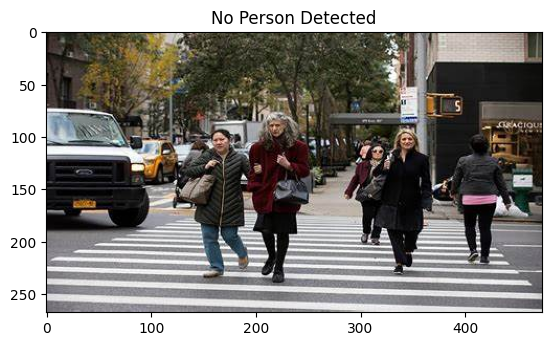

In [21]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped.jpg', device, val_transform)


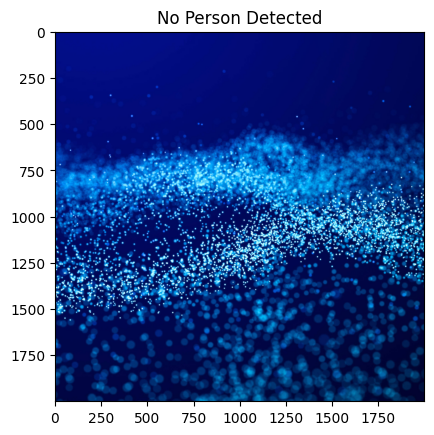

In [24]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg.jpg', device, val_transform)


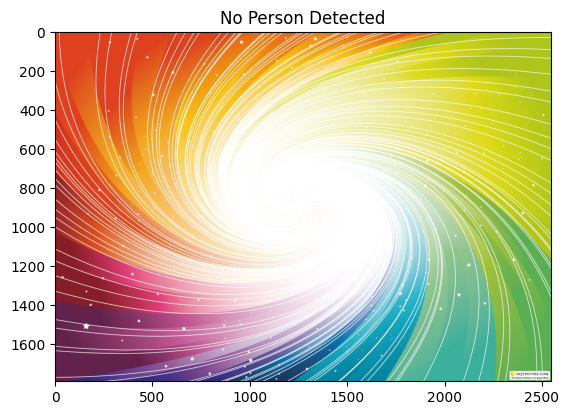

In [23]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg2.jpg', device, val_transform)


In [78]:
# ==================== Model Architecture ====================

class ImprovedObjectDetectionCNN(nn.Module):
    def __init__(self):
        super(ImprovedObjectDetectionCNN, self).__init__()

        # Feature extraction backbone
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5))

        # Output heads
        self.class_head = nn.Linear(512, 1)
        self.bbox_head = nn.Linear(512, 4)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        class_out = torch.sigmoid(self.class_head(x))
        bbox_out = self.bbox_head(x)

        return class_out, bbox_out

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25: Train Loss: 1.2278 | Val Loss: 0.8122 | Train Acc: 0.5487 | Val Acc: 0.5677 | Train IoU: 0.1235 | Val IoU: 0.2492
Epoch 2/25: Train Loss: 0.8723 | Val Loss: 0.9230 | Train Acc: 0.5760 | Val Acc: 0.5419 | Train IoU: 0.1959 | Val IoU: 0.1058
Epoch 3/25: Train Loss: 0.8322 | Val Loss: 0.7921 | Train Acc: 0.6169 | Val Acc: 0.6516 | Train IoU: 0.2034 | Val IoU: 0.1719
Epoch 4/25: Train Loss: 0.7995 | Val Loss: 0.7279 | Train Acc: 0.6533 | Val Acc: 0.7032 | Train IoU: 0.2139 | Val IoU: 0.1993
Epoch 5/25: Train Loss: 0.7845 | Val Loss: 0.7729 | Train Acc: 0.6606 | Val Acc: 0.7677 | Train IoU: 0.2189 | Val IoU: 0.1449
Epoch 6/25: Train Loss: 0.7521 | Val Loss: 0.7145 | Train Acc: 0.7025 | Val Acc: 0.7677 | Train IoU: 0.2257 | Val IoU: 0.1431
Epoch 7/25: Train Loss: 0.7089 | Val Loss: 0.6642 | Train Acc: 0.7216 | Val Acc: 0.7742 | Train IoU: 0.2273 | Val IoU: 0.1515
Epoch 8/25: Train Loss: 0.6763 | Val Loss: 0.6416 | Train Acc: 0.7561 | Val Acc: 0.7548 | Train IoU: 0.2228 | Val IoU:

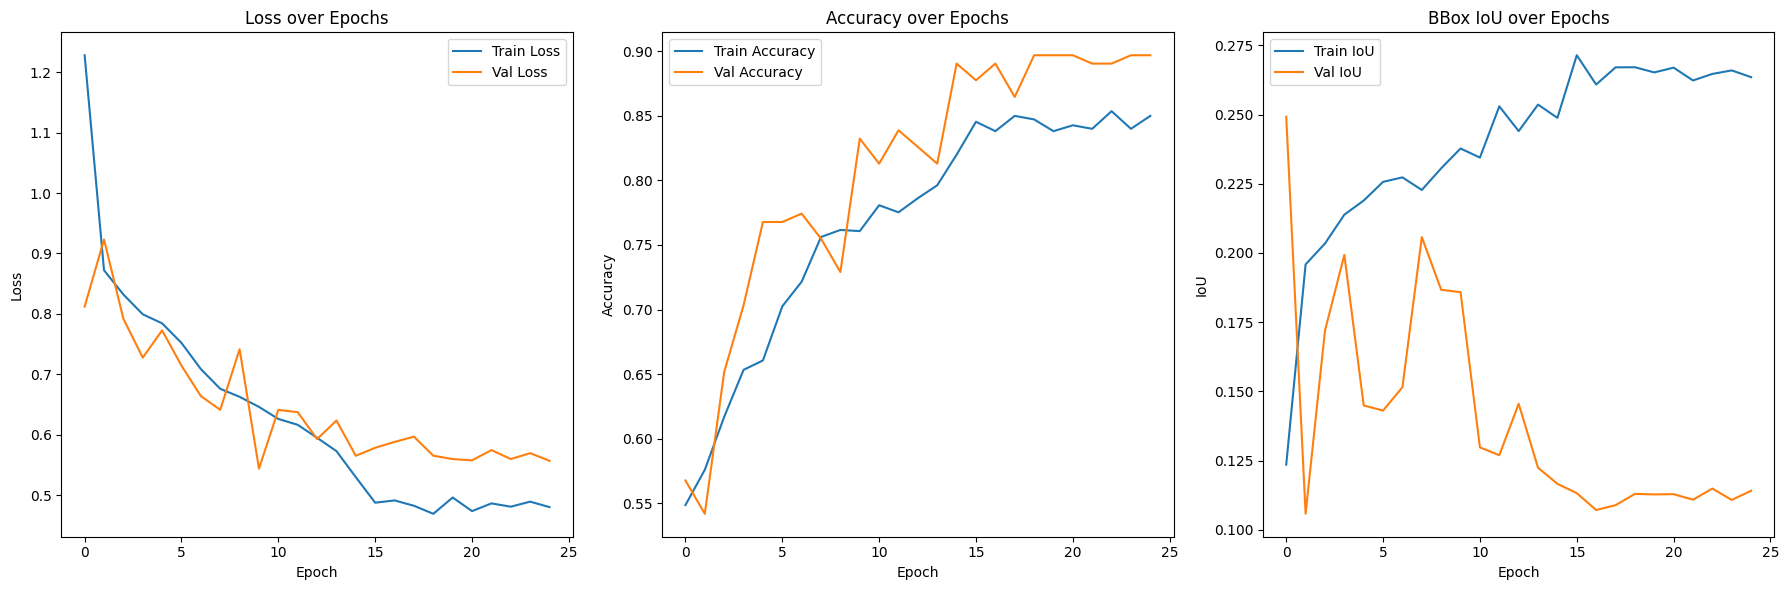


Final Test Results:
Test Loss: 0.6872
Test Accuracy: 0.7234
Test BBox IoU: 0.1633


In [62]:
# Initialize model
model = ImprovedObjectDetectionCNN().to(device)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Train the model
history = train_model(model, train_loader, val_loader, optimizer, device, epochs=25)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_iou = evaluate_model(
    model, test_loader,
    nn.BCELoss(), nn.SmoothL1Loss(), device
)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test BBox IoU: {test_iou:.4f}")


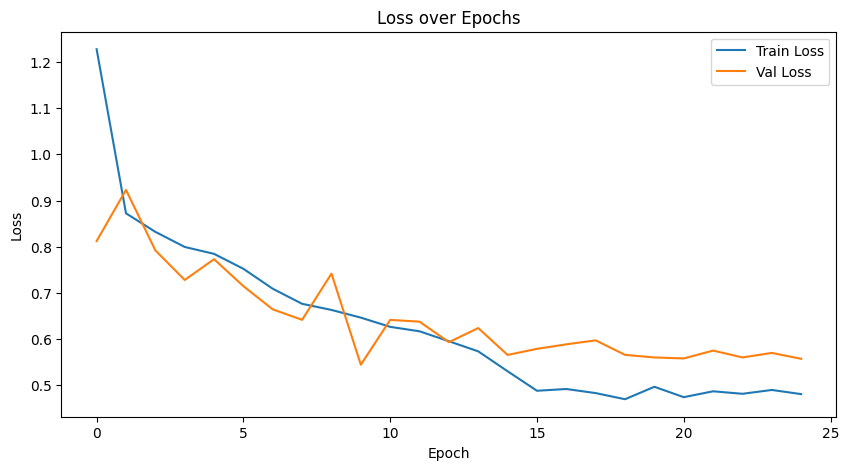

In [85]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

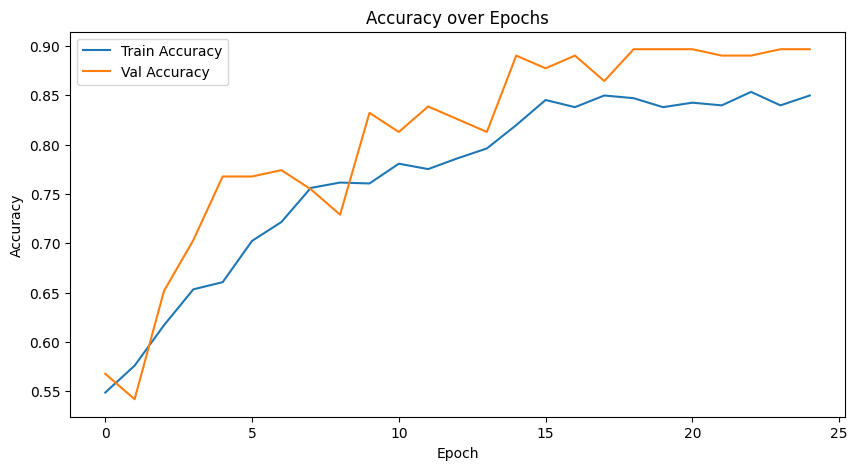

In [86]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

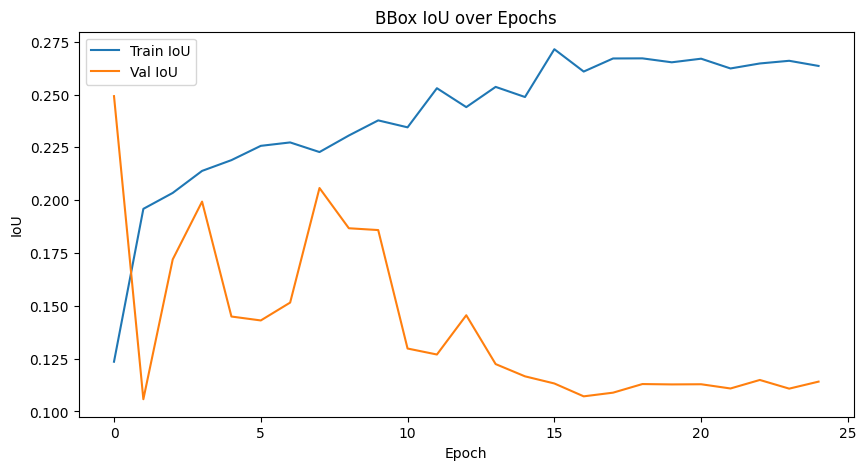

In [87]:
# IoU plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.title('BBox IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [69]:
# save model to drive"
model_save_path = "/content/drive/MyDrive/combined_dataset/best_model.pth"
torch.save(model.state_dict(), model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


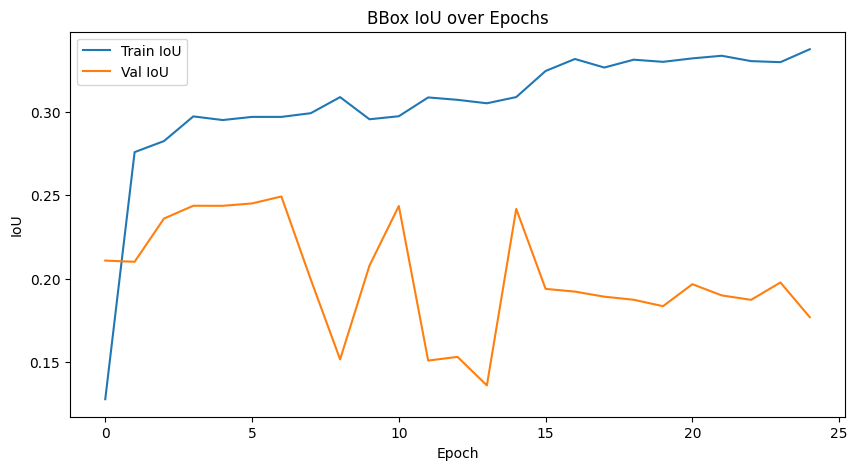

In [98]:
# IoU plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.title('BBox IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

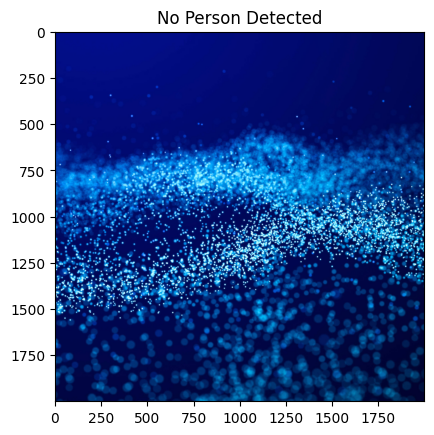

In [73]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg.jpg', device, val_transform)


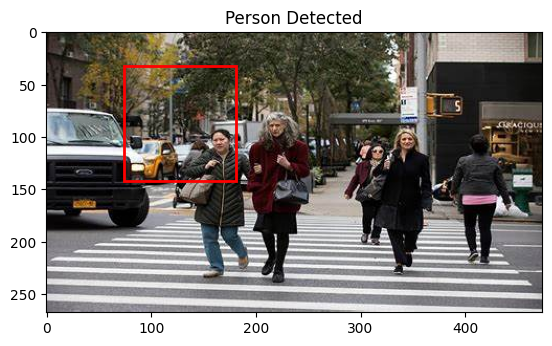

In [72]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped.jpg', device, val_transform)


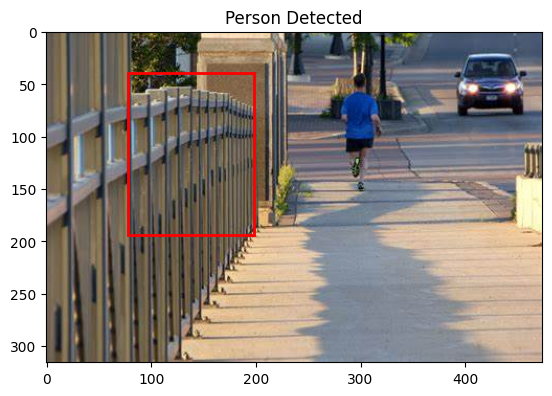

In [71]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/ped1.jpg', device, val_transform)


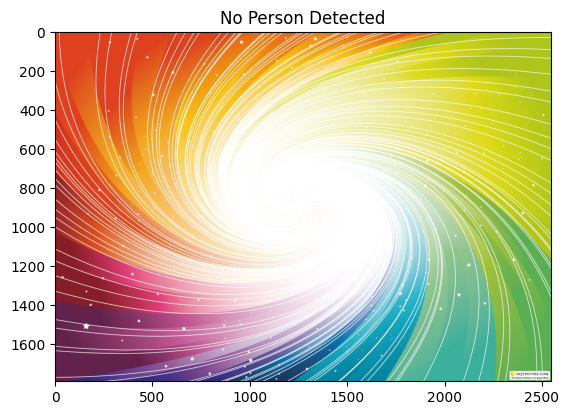

In [70]:
# Example usage (assuming you have a 'test_image.jpg' in your current directory and a trained model)
predict_and_visualize(model, '/content/drive/MyDrive/combined_dataset/unknown images/bg2.jpg', device, val_transform)
